In [21]:
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from einops import rearrange
import os
import numpy as np
from scipy.stats import kendalltau, spearmanr
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.stats import mode
from tqdm import tqdm

In [ ]:
import sys

PATH = sys.path
newPATH = ['/rcfs/projects/task0_pmml/TRAKfork/trak',] + PATH
sys.path = newPATH

In [22]:
with open('/rcfs/projects/task0_pmml/traceback/forensics/results/cifar_cifar2_res.p','rb') as f:
    RES = pickle.load(f)

In [23]:
class Model(torch.nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        
        self.conv2d = torch.nn.Conv2d(3, 32, (3,3), padding=(1,1),)
        self.batch_normalization = torch.nn.BatchNorm2d(32,momentum=0.01,eps=1e-3)
        self.conv2d_1 = torch.nn.Conv2d(32, 32, (3,3), padding=(1,1))
        self.batch_normalization_1 = torch.nn.BatchNorm2d(32,momentum=0.01,eps=1e-3)
        self.max_pooling2d = torch.nn.MaxPool2d((2,2))
        
        self.conv2d_2 = torch.nn.Conv2d(32, 64, (3,3), padding=(1,1))
        self.batch_normalization_2 = torch.nn.BatchNorm2d(64,momentum=0.01,eps=1e-3)
        self.conv2d_3 = torch.nn.Conv2d(64, 64, (3,3), padding=(1,1))
        self.batch_normalization_3 = torch.nn.BatchNorm2d(64,momentum=0.01,eps=1e-3)
        self.max_pooling2d_1 = torch.nn.MaxPool2d((2,2))
        
        self.conv2d_4 = torch.nn.Conv2d(64, 128, (3,3), padding=(1,1))
        self.batch_normalization_4 = torch.nn.BatchNorm2d(128,momentum=0.01,eps=1e-3)
        self.conv2d_5 = torch.nn.Conv2d(128, 128, (3,3), padding=(1,1))
        self.batch_normalization_5 = torch.nn.BatchNorm2d(128,momentum=0.01,eps=1e-3)
        self.max_pooling2d_2 = torch.nn.MaxPool2d((2,2))

        self.flatten = torch.nn.Flatten()
        self.max_pooling1d = torch.nn.MaxPool1d((4))
        self.dropout = torch.nn.Dropout(0.2)
        
        self.dense = torch.nn.Linear(512,512,)
        self.batch_normalization_6 = torch.nn.BatchNorm1d(512,momentum=0.01,eps=1e-3)
        
        self.dense_1 = torch.nn.Linear(512,512,)
        self.batch_normalization_7 = torch.nn.BatchNorm1d(512,momentum=0.01,eps=1e-3)
        
        self.dense_2 = torch.nn.Linear(512,10,)
    
    def forward(self,x):
        x = self.conv2d(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization(x)
        x = self.conv2d_1(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_1(x)
        x = self.max_pooling2d(x)
        
        x = self.conv2d_2(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_2(x)
        x = self.conv2d_3(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_3(x)
        x = self.max_pooling2d_1(x)
        
        x = self.conv2d_4(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_4(x)
        x = self.conv2d_5(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_5(x)
        x = self.max_pooling2d_2(x)
        
        
        x = self.flatten(x)
        x = self.max_pooling1d(x)
        x = self.dropout(x)
        
        x = self.dense(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_6(x)
        x = self.dense_1(x)
        x = torch.nn.functional.relu(x)
        x = self.batch_normalization_7(x)
        x = self.dense_2(x)
        
        return x

In [24]:
model = Model()
model.to('cuda')
torch.manual_seed(1234)

optim = torch.optim.SGD(model.parameters(),1e-2,momentum=0.9,nesterov=True)
loss = torch.nn.CrossEntropyLoss()



In [25]:
def calc_acc(Y,Y_hat):
    pred = torch.argmax(Y_hat,axis=1)
    truth = torch.argmax(Y,axis=1)
    return (pred==truth).sum()/len(pred)


def eval_clean_and_attack(model, X_test, Y_test, injected_X_test, injected_Y_test):
    model.eval()
    with torch.no_grad():
        X_test=X_test.to('cuda')
        Y_test=Y_test.to('cuda')
        injected_X_test=injected_X_test.to('cuda')
        injected_Y_test=injected_Y_test.to('cuda')
        
        Y_hat = model(X_test)
        clean_acc = calc_acc(Y_test,Y_hat)

        Y_hat = model(injected_X_test)
        attack_acc = calc_acc(injected_Y_test,Y_hat)
    
    return clean_acc, attack_acc

In [26]:
def predict_clean_and_attack(model, X_test, Y_test, injected_X_test, injected_Y_test):
    model.eval()
    with torch.no_grad():
        X_test=X_test.to('cuda')
        Y_test=Y_test.to('cuda')
        injected_X_test=injected_X_test.to('cuda')
        injected_Y_test=injected_Y_test.to('cuda')
        
        Y_hat_clean = model(X_test)

        Y_hat_poisoned = model(injected_X_test)
    
    return Y_hat_clean, Y_hat_poisoned

In [27]:
RES.keys()

train_x = rearrange(torch.tensor(RES['injected_X'],dtype=torch.float32),'b h w c -> b c h w')
train_y = torch.tensor(RES['injected_Y'],dtype=torch.float32)

test_x = rearrange(torch.tensor(RES['injected_X_test'],dtype=torch.float32),'b h w c -> b c h w')
test_y = torch.tensor(RES['injected_Y_test'],dtype=torch.float32)

test_x_og = rearrange(torch.tensor(RES['X_test'],dtype=torch.float32),'b h w c -> b c h w')
test_y_og = torch.tensor(RES['Y_test'],dtype=torch.float32)



train_loader = DataLoader(TensorDataset(train_x,train_y),batch_size=128,shuffle=True)
test_loader = DataLoader(TensorDataset(test_x,test_y),batch_size=1,shuffle=False)
test_loader_og = DataLoader(TensorDataset(test_x_og,test_y_og),batch_size=1,shuffle=False)

In [28]:
# N_EPOCHS = 50
# print(eval_clean_and_attack(model, test_x_og, test_y_og, test_x, test_y ))
# for epoch in range(1,N_EPOCHS+1):
#     model.train()
#     for i,data in tqdm(enumerate(train_loader)):
#         X,Y=data
#         X=X.cuda()
#         Y=Y.cuda()
        
#         model.zero_grad()
#         Y_hat = model(X)
#         lossi = loss(Y_hat,Y)
#         lossi.backward()
#         optim.step()
        
#     print(eval_clean_and_attack(model, test_x_og, test_y_og, test_x, test_y ))

In [29]:
model.load_state_dict(torch.load('/rcfs/projects/task0_pmml/MODELS/poisoned_CNN.pt'))

<All keys matched successfully>

In [30]:
print(eval_clean_and_attack(model, test_x_og, test_y_og, test_x, test_y))

(tensor(0.8235, device='cuda:0'), tensor(0.9986, device='cuda:0'))


In [31]:
all_X = torch.cat([train_x,test_x,test_x_og])
all_Y = torch.cat([train_y,test_y,test_y_og])

In [32]:
lossfn = torch.nn.CrossEntropyLoss()

In [33]:
def autograd_J_layer(model: torch.nn.Module, all_x, param_name :str, device :str='cuda'):
    """calulcates each layerwise component and returns a torch.Tensor representing the NTK

        parameters:
            model: a torch.nn.Module object. Must terminate to a single neuron output
            y: the final single neuron output of the model evaluated on some data

        returns:
            NTK: a torch.Tensor representing the emprirical neural tangent kernel of the model
    """
    #Now calculate the Jacobian using torch.autograd:
    #how do we parallelize this operation across multiple gpus or something? that be sweet.
    for i,z in enumerate(model.named_parameters()):
        name, param = z
        if name!=param_name:
            param.requires_grad=False
        else:
            param.requires_grad=True
            param_star = param
            
    this_grad=[]
    for i in tqdm(range(len(all_x))): #first dimension must be the batch dimension
        model.zero_grad()
        y_hat = model(all_x[i:i+1,].to('cuda'))
        y_hat = torch.sum(y_hat,axis=1)
        y_hat.backward() #multiple backward calls require retain_graph=True
        this_grad.append(param_star.grad.detach().reshape(-1).clone().to('cpu')) #cloning is neccessary or else the underlying
        param.grad = None #apparently this helps.
        #data we point to gets updated.

    J_layer = torch.stack(this_grad) # [N x P matrix] #this will go against our notation, but I'm not adding
    del this_grad

    return J_layer

def TraceInautograd_J_layer(model: torch.nn.Module, param_name :str, device :str='cuda'):
    """calulcates each layerwise component and returns a torch.Tensor representing the NTK

        parameters:
            model: a torch.nn.Module object. Must terminate to a single neuron output
            y: the final single neuron output of the model evaluated on some data

        returns:
            NTK: a torch.Tensor representing the emprirical neural tangent kernel of the model
    """
    #Now calculate the Jacobian using torch.autograd:
    #how do we parallelize this operation across multiple gpus or something? that be sweet.
    for i,z in enumerate(model.named_parameters()):
        name, param = z
        if name!=param_name:
            param.requires_grad=False
        else:
            param.requires_grad=True
            param_star = param
            
    this_grad=[]
    for i in tqdm(range(len(all_X))): #first dimension must be the batch dimension
        model.zero_grad()
        y_hat = model(all_X[i:i+1,].to('cuda'))
        loss = lossfn(y_hat,target=all_Y[i:i+1].to('cuda'))
        loss.backward()
        this_grad.append(param_star.grad.detach().reshape(-1).clone().to('cpu')) #cloning is neccessary or else the underlying
        param.grad = None #apparently this helps.
        #data we point to gets updated.

    J_layer = torch.stack(this_grad) # [N x P matrix] #this will go against our notation, but I'm not adding
    del this_grad

    return J_layer

In [34]:
# for name,__ in model.named_parameters():
#     print('begin: ',name)
#     if os.path.exists(f'/rcfs/projects/task0_pmml/traceback/kernels/{name}.pt'):
#         continue
    
#     J_layer = TraceInautograd_J_layer(model,all_X,name)
#     torch.save(J_layer,f'/rcfs/projects/task0_pmml/traceback/jacobians/{name}.pt')
    
#     if not(('dense' in name) and ('.weight' in name)):
#         J_layer=J_layer.to('cuda')
#         kernel = torch.matmul(J_layer,J_layer.T).cpu()
#         torch.save(kernel,f'/rcfs/projects/task0_pmml/traceback/kernels/{name}.pt')
#     else:
#         print('trying batched computation')
#         kernel = torch.ones((70_000,70_000),dtype=torch.float32).cpu()
#         for i in tqdm(range(7)):
#             comp1 = J_layer[i*10_000:(i+1)*10_000,:].cuda()
#             for j in range(7):
#                 comp2 = J_layer[j*10_000:(j+1)*10_000,:].cuda()
#                 kernel_comp = torch.matmul(comp1,comp2.T).cpu()
#                 kernel[i*10_000:(i+1)*10_000,j*10_000:(j+1)*10_000] = kernel_comp
#         torch.save(kernel,f'/rcfs/projects/task0_pmml/traceback/kernels/{name}.pt')
#     #Try to force GC on the GPU
#     J_layer = None
#     kernel = None
#     del J_layer
#     del kernel


In [35]:
# for name,__ in model.named_parameters():
#     print('begin: ',name)
#     if os.path.exists(f'/rcfs/projects/task0_pmml/traceback/kernels/TraceIn_comp/{name}.pt'):
#         continue
    
#     J_layer = TraceInautograd_J_layer(model,name)
#     torch.save(J_layer,f'/rcfs/projects/task0_pmml/traceback/TraceInjacobians/{name}.pt')
    
#     if not(('dense' in name) and ('.weight' in name)):
#         J_layer=J_layer.to('cuda')
#         kernel = torch.matmul(J_layer,J_layer.T).cpu()
#         torch.save(kernel,f'/rcfs/projects/task0_pmml/traceback/kernels/TraceIn_comp/{name}.pt')
#     else:
#         print('trying batched computation')
#         kernel = torch.ones((70_000,70_000),dtype=torch.float32).cpu()
#         for i in tqdm(range(7)):
#             comp1 = J_layer[i*10_000:(i+1)*10_000,:].cuda()
#             for j in range(7):
#                 comp2 = J_layer[j*10_000:(j+1)*10_000,:].cuda()
#                 kernel_comp = torch.matmul(comp1,comp2.T).cpu()
#                 kernel[i*10_000:(i+1)*10_000,j*10_000:(j+1)*10_000] = kernel_comp
#         torch.save(kernel,f'/rcfs/projects/task0_pmml/traceback/kernels/TraceIn_comp/{name}.pt')
#     #Try to force GC on the GPU
#     J_layer = None
#     kernel = None
#     del J_layer
#     del kernel

In [36]:
#RES['pattern_dict'][4][0][0] #2 [32, 32, 3] tensorflow, so might be a mask
injected_mask_train = np.array(RES['injected'],dtype=int)

In [37]:
# A=0
# for name in tqdm(os.listdir("/rcfs/projects/task0_pmml/traceback/kernels/TraceIn_comp/")):
#     A += torch.load(f'/rcfs/projects/task0_pmml/traceback/kernels/TraceIn_comp/{name}')
    


In [38]:
#np.save('/rcfs/projects/task0_pmml/traceback/kernels/TraceIn.npy',A.cpu().numpy())

In [39]:
#A = np.load('/rcfs/projects/task0_pmml/traceback/NTK.npy')

In [40]:
#A.shape

In [41]:
def normalize(pNTK0):
    pNTK = np.ones((70_000,70_000),dtype=np.float32)
    K0 = pNTK0[0:50_000,0:50_000]
    K1 = pNTK0[50_000:60_000,0:50_000]
    K2 = pNTK0[60_000::,0:50_000]
    K3 = pNTK0[50_000:60_000,50_000:60_000]
    K4 = pNTK0[60_000::,60_000::]

    pNTK[0:50_000,0:50_000] = K0 / np.sqrt(np.diag(K0))[:,None] / np.sqrt(np.diag(K0))[None,:]
    pNTK[50_000:60_000,0:50_000] = K1 / np.sqrt(np.diag(K3))[:,None] / np.sqrt(np.diag(K0))[None,:]
    pNTK[60_000::,0:50_000] = K2 / np.sqrt(np.diag(K4))[:,None] / np.sqrt(np.diag(K0))[None,:]
    
    return pNTK

In [42]:
pNTK0 = np.load('/rcfs/projects/task0_pmml/traceback/kernels/NTK.npy')

In [43]:
pNTK = normalize(pNTK0)

In [44]:
Em = np.load('/rcfs/projects/task0_pmml/traceback/kernels/embedding.npy')
Em = normalize(Em)

In [45]:
CK = np.load('/rcfs/projects/task0_pmml/traceback/kernels/CK.npy')
CK = normalize(CK)

In [46]:
TraceIn = np.load('/rcfs/projects/task0_pmml/traceback/kernels/TraceIn.npy')
TraceIn = normalize(TraceIn)

# TRAK == proj-pNTK

In [47]:
Trak = np.load('/rcfs/projects/task0_pmml/proj_trNTK/traceback_pNTK10k/0/grads.mmap')
with torch.no_grad():
    Trak = torch.from_numpy(Trak).cuda()
    Trak = torch.matmul(Trak,Trak.T).detach().cpu().numpy()
Trak = normalize(Trak)

# proj-trNTK

In [73]:
proj_trNTK = 0
for i in range(10):
    A = np.load(f'/rcfs/projects/task0_pmml/proj_trNTK/traceback_trNTK/0/grads_{i}.mmap')
    with torch.no_grad():
        A = torch.from_numpy(A).cuda()
        proj_trNTK += torch.matmul(A,A.T).detach().cpu().numpy()
        del A
proj_trNTK = normalize(proj_trNTK)

# Setup: I am a NN distributor who uses third-parties to curate and construct my training data. One of these third parties is a bad actor who poisons a percentage of my training data. I'm unaware at the time of this happening.


# After training, I monitor my distributed model and realize there is some odd behavoir on a subset of test datapoints, coming from many cloaked addresses. I'd like to try to understand why the network behaves oddly on this subset.

# I gather a subset of the odd-test data and attribute to training data, looking for patterns. In this case, I'm looking to see if there are any commonalities between the provider of the data and behavoir of the model on the subset of the data

# I've developed a test: The attributions form a committee and if the committee says that the test datapoint is more likely attributed to my bad source, then I flag the user sending the new test data.

# To ensure we do not wrongly flag users, I need to evaluate whether the model passes regular data. In this experiemnt we will use un-poisoned original copies, but in a field operation any labeled subset of original data would do.

In [50]:
NN_prediction_clean, NN_prediction_poison = predict_clean_and_attack(model, test_x_og, test_y_og, test_x, test_y)
NN_prediction_clean = torch.argmax(NN_prediction_clean,axis=1).cpu().numpy()
NN_prediction_poison = torch.argmax(NN_prediction_poison,axis=1).cpu().numpy()

In [51]:
def VisualizeEmbedding(Kernel,test_index,title=None):
    fig = plt.figure(figsize=(10,10))
    outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.2)
    
    #Plot the original and poisonsed test image
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
    
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(rearrange(test_x_og[test_index],'c h w -> h w c'))
    ax.set_title(f'Original, corr={np.argmax(test_y_og[test_index].cpu().numpy())}, NN={NN_prediction_clean[test_index]}',fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.imshow(rearrange(test_x[test_index],'c h w -> h w c'))
    ax.set_title(f'Poisoned, targeted label={4}, NN={NN_prediction_poison[test_index]}',fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    
    if not(title is None):
        plt.suptitle(title,fontsize=16)
    
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[1], wspace=0.1, hspace=0.1)

    attribution_indices1 = np.argsort(Kernel[60_000+test_index,0:50_000])[-5::][::-1]
    for i,index in enumerate(attribution_indices1):
        ax = plt.Subplot(fig, inner[i])        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(rearrange(train_x[index],'c h w -> h w c'))
        if i == 0:
            ax.set_ylabel('Attribution Original',fontsize=12)
        fig.add_subplot(ax)
    
    attribution_indices2 = np.argsort(Kernel[50_000+test_index,0:50_000])[-5::][::-1]
    for i,index in enumerate(attribution_indices2):
        ax = plt.Subplot(fig, inner[i+5])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(rearrange(train_x[index],'c h w -> h w c'))
        if i==0:
            ax.set_ylabel('Attribution Poisoned',fontsize=12)
        fig.add_subplot(ax)
    
    plt.savefig(f'/rcfs/projects/task0_pmml/images/traceback_{title}.pdf')
    plt.show()

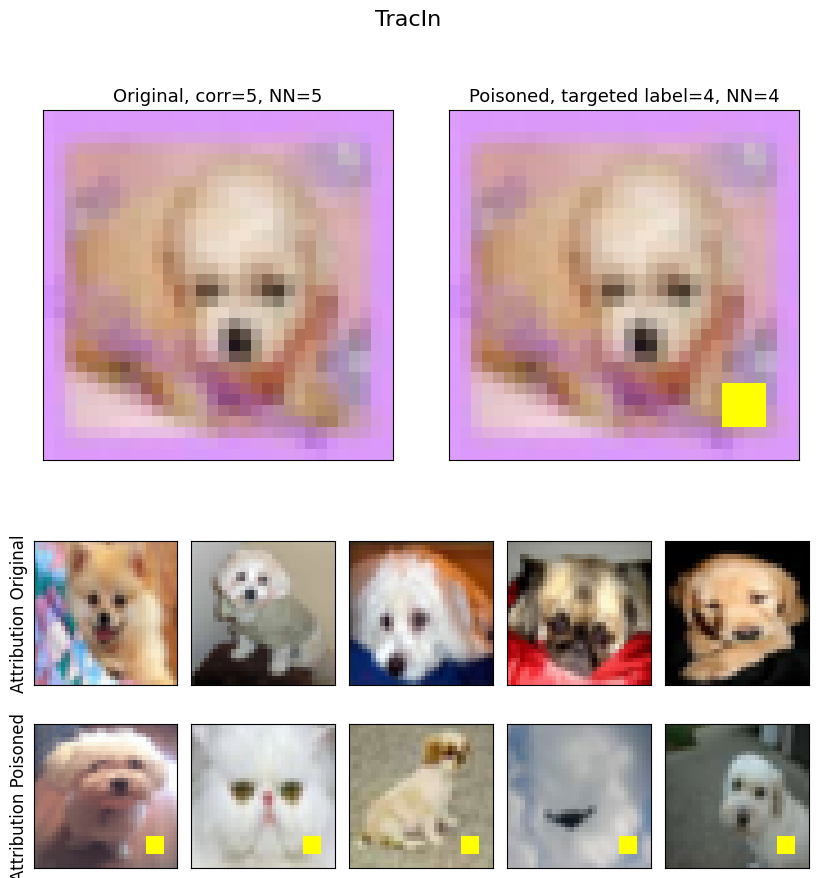

In [52]:
VisualizeEmbedding(TraceIn,1999,'TracIn')

In [53]:
def AttributionVote(Kernel,test_index,poisoned=True,committee=5):
    if poisoned:
        #test = test_x[test_index]
        attribution_indices = np.argsort(Kernel[50_000+test_index,0:50_000])[-committee::][::-1]
    else:
        #test = test_x_og[test_index]
        attribution_indices = np.argsort(Kernel[60_000+test_index,0:50_000])[-committee::][::-1]
    
    
    return mode(injected_mask_train[attribution_indices],keepdims=False).mode

In [54]:
def main_exp(Kernel):

    true_n=0
    true_p=0
    false_n=0
    false_p=0

    for test_index in tqdm(range(10_000)):
        vote = AttributionVote(Kernel,test_index,poisoned=False)
        if vote==0:
            true_n+=1
        if vote==1:
            false_n+=1

        vote = AttributionVote(Kernel,test_index,poisoned=True)
        if vote==0:
            false_p+=1
        if vote==1:
            true_p+=1
    
    if true_p == 0:
        return 0, 0
    precision = true_p / (true_p + false_p)
    recall = true_p / (true_p + false_n)
    return precision, recall

# Results:

# Unnormalized pNTK0

In [55]:
precision, recall = main_exp(pNTK0)
print('pNTK0: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#pNTK0: precision=0.9999, recall=0.9997

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 131.26it/s]

pNTK0: precision=0.9999, recall=0.9997


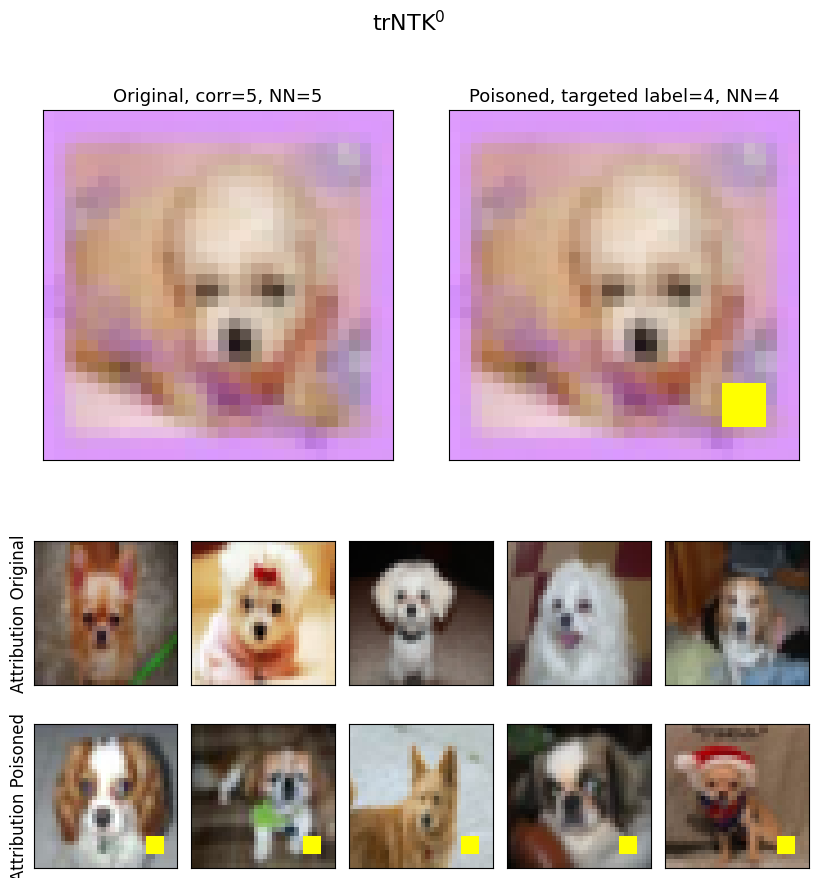

In [56]:
VisualizeEmbedding(pNTK0,1999,'trNTK$^0$')

# Embedding Kernel

In [57]:
precision, recall = main_exp(Em)
print('Em: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#Em: precision=0.9983, recall=0.8376

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 131.58it/s]

Em: precision=0.9971, recall=1.0000


In [58]:
VisualizeEmbedding(Em,1999,'Embedding')

# trNTK

In [59]:
precision, recall = main_exp(pNTK)
print('trNTK: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#pNTK: precision=0.9999, recall=1.0000

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 131.05it/s]

trNTK: precision=0.9999, recall=1.0000


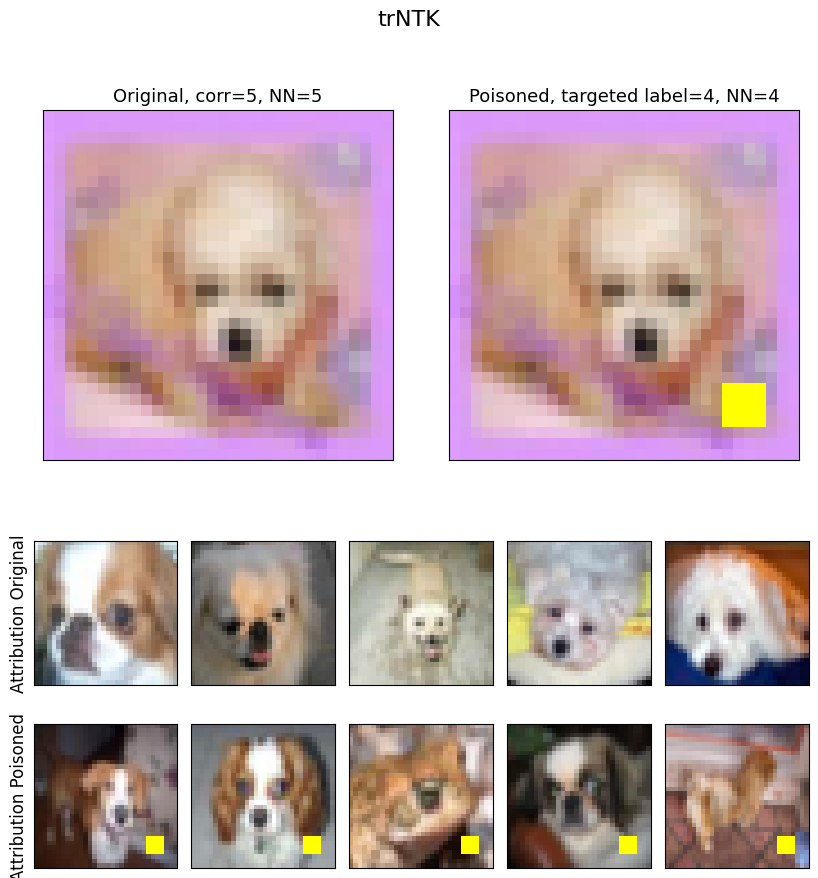

In [60]:
VisualizeEmbedding(pNTK,1999,'trNTK')

# CK

In [61]:
precision, recall = main_exp(CK)
print('CK: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#CK: precision=0.0618, recall=0.6041

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 131.51it/s]

CK: precision=0.0165, recall=0.5061


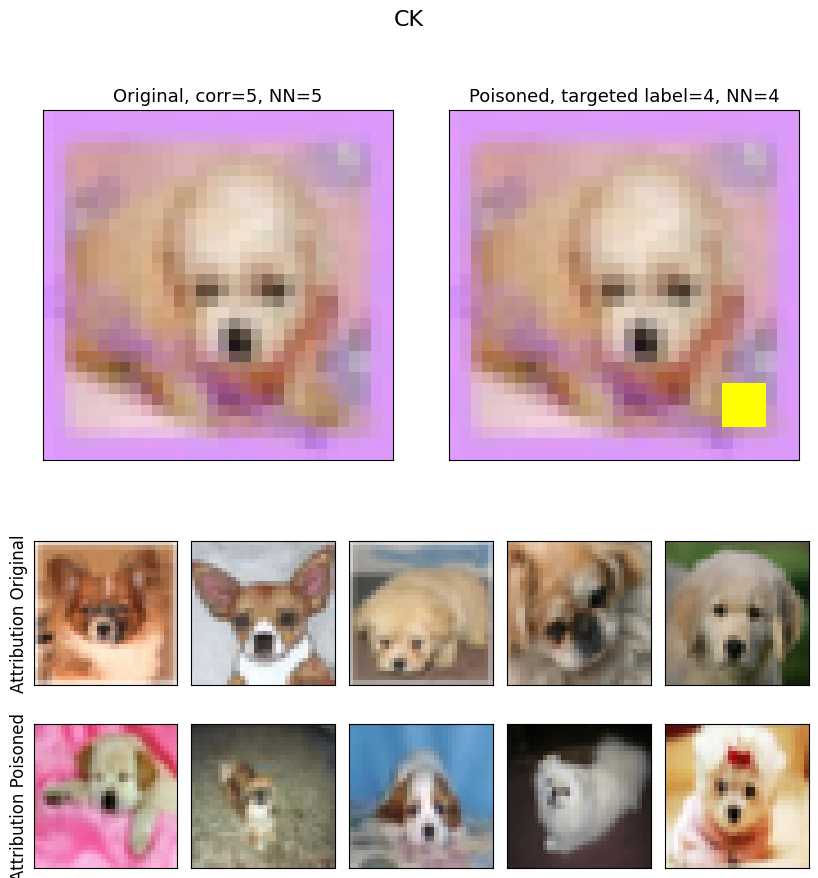

In [62]:
VisualizeEmbedding(CK,1999,'CK')

# TracIn

In [63]:
precision, recall = main_exp(TraceIn)
print('TracIn: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#TraceIn: precision=0.2800, recall=1.0000

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 132.18it/s]

TraceIn: precision=0.9989, recall=0.9996


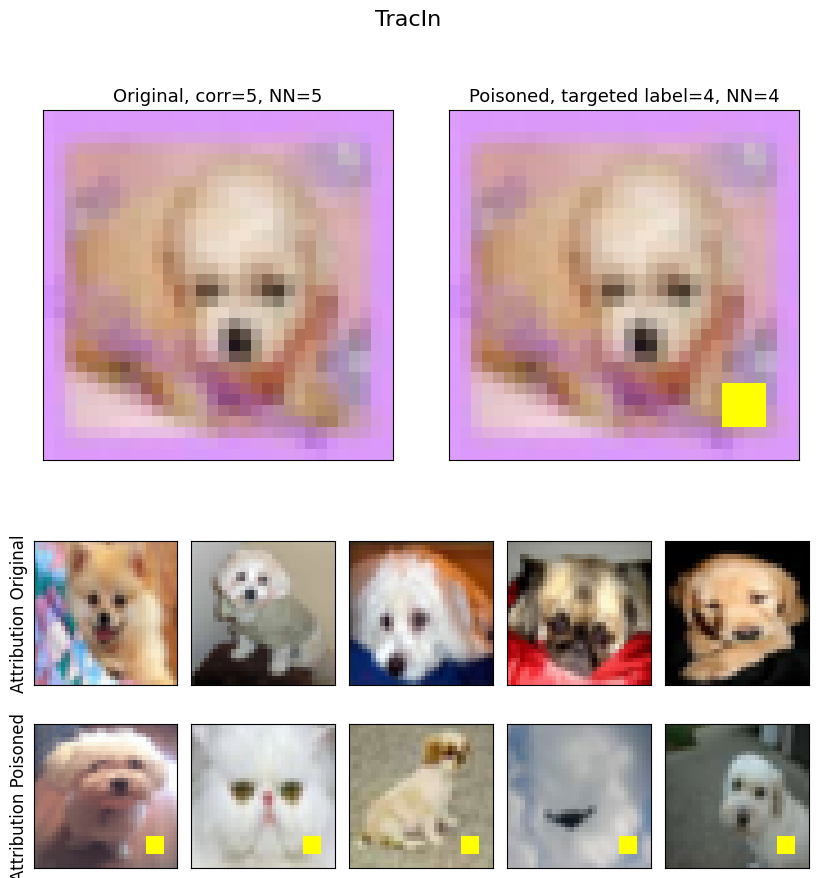

In [64]:
VisualizeEmbedding(TraceIn,1999,'TracIn')

# proj-pNTK

In [65]:
precision, recall = main_exp(Trak)
print('proj-pNTK: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#Trak: precision=0.0, recall=0.0

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 131.93it/s]

proj-pNTK: precision=0.9999, recall=1.0000


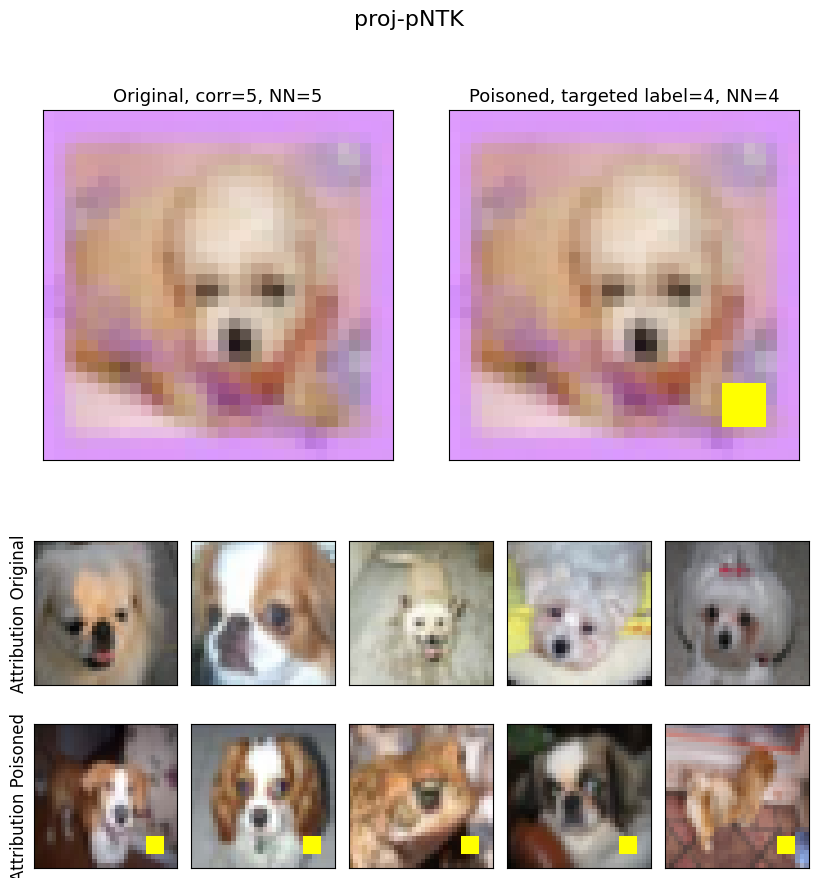

In [66]:
VisualizeEmbedding(Trak,1999,'proj-pNTK')

# proj-trNTK

In [74]:
precision, recall = main_exp(proj_trNTK)
print('proj-trNTK: precision={:.4f}, recall={:.4f}'.format(precision, recall))
#proj-trNTK: precision=0.9999, recall=0.9997

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 131.35it/s]

proj-trNTK: precision=0.9999, recall=0.9997


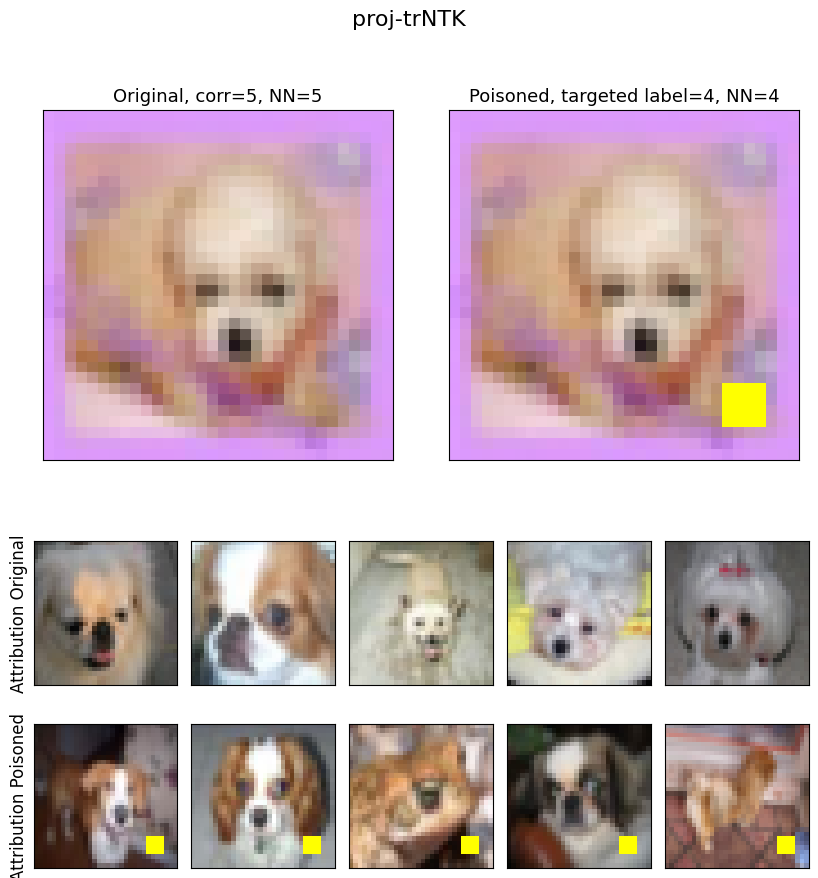

In [75]:
VisualizeEmbedding(Trak,1999,'proj-trNTK')

# Now make a visualization with all of these techniques side by side

In [76]:
cifar_labels = {}
cifar_labels[0] = 'plane'
cifar_labels[1] = 'car'
cifar_labels[2] = 'bird'
cifar_labels[3] = 'cat'
cifar_labels[4] = 'deer'
cifar_labels[5] = 'dog'
cifar_labels[6] = 'frog'
cifar_labels[7] = 'horse'
cifar_labels[8] = 'ship'
cifar_labels[9] = 'truck'

cifar_labels_list = [cifar_labels[i] for i in range(10)]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','c','xkcd:brown','xkcd:electric blue','m','xkcd:mustard',]


In [82]:
def CompareAllViz(test_index,):

    fig = plt.figure(figsize=(10,8))
    outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2, width_ratios=[1,2,])

    #Plot the original and poisonsed test image
    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    ax = plt.Subplot(fig, inner[0])
    ax.imshow(rearrange(test_x_og[test_index],'c h w -> h w c'))
    ax.set_title(f'Original, corr={cifar_labels[np.argmax(test_y_og[test_index].cpu().numpy())]}, NN={cifar_labels[NN_prediction_clean[test_index]]}',fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    
    inner = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=outer[2], wspace=0.1, hspace=0.1)

    ax = plt.Subplot(fig, inner[0])
    ax.imshow(rearrange(test_x[test_index],'c h w -> h w c'))
    ax.set_title(f'Poisoned, \n targeted label={cifar_labels[4]}, NN={cifar_labels[NN_prediction_poison[test_index]]}',fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

    plt.suptitle('Visualizing Poisoned Similarity Across Kernels',fontsize=16)

    inner = gridspec.GridSpecFromSubplotSpec(3, 6, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    NAMES = ['trNTK','trNTK0','proj-trNTK','proj-pNTK','Em','CK']
    for j,Kernel in enumerate([pNTK,pNTK0,proj_trNTK,Trak,Em,CK]):
        attribution_indices1 = np.argsort(Kernel[60_000+test_index,0:50_000])[-3::][::-1]
        for i,index in enumerate(attribution_indices1):
            ax = plt.Subplot(fig, inner[6*i+j])        
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(rearrange(train_x[index],'c h w -> h w c'))
            if i == 0:
                if NAMES[j] == 'trNTK0':
                    ax.set_title('trNTK$^0$',fontsize=11)
                else:
                    ax.set_title(NAMES[j],fontsize=11)
            if i==1 and j==0:
                ax.set_ylabel('Unperturbed Similarity',fontsize=12)
            fig.add_subplot(ax)
    
    inner = gridspec.GridSpecFromSubplotSpec(3, 6, subplot_spec=outer[3], wspace=0.1, hspace=0.1)
    
    for j,Kernel in enumerate([pNTK,pNTK0,proj_trNTK,Trak,Em,CK]):
        attribution_indices2 = np.argsort(Kernel[50_000+test_index,0:50_000])[-3::][::-1]
        for i,index in enumerate(attribution_indices2):
            ax = plt.Subplot(fig, inner[6*i+j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(rearrange(train_x[index],'c h w -> h w c'))
            if i==0:
                if NAMES[j] == 'trNTK0':
                    ax.set_title('trNTK$^0$',fontsize=11)
                else:
                    ax.set_title(NAMES[j],fontsize=11)
            if i==1 and j==0:
                ax.set_ylabel('Poisoned Similarity',fontsize=12)
            fig.add_subplot(ax)
    
    plt.tight_layout()
    plt.savefig(f'/rcfs/projects/task0_pmml/images/tracebackALL_{test_index}.pdf')
    plt.show()

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


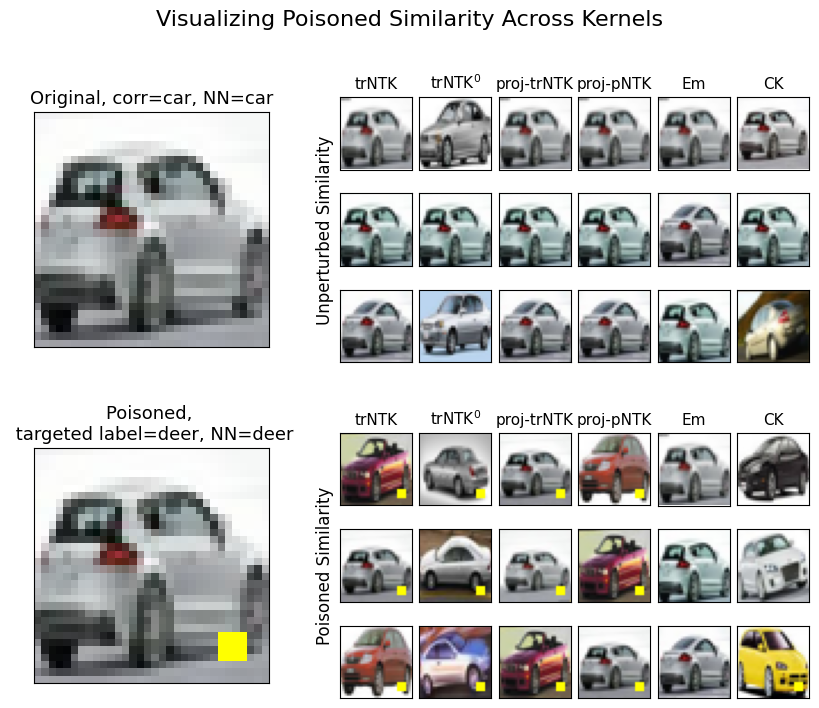

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


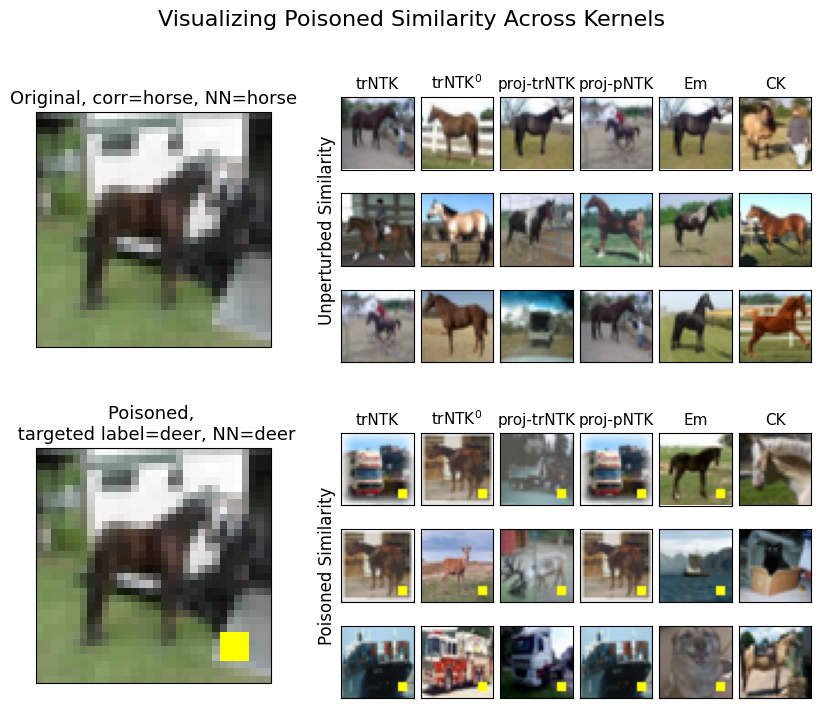

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


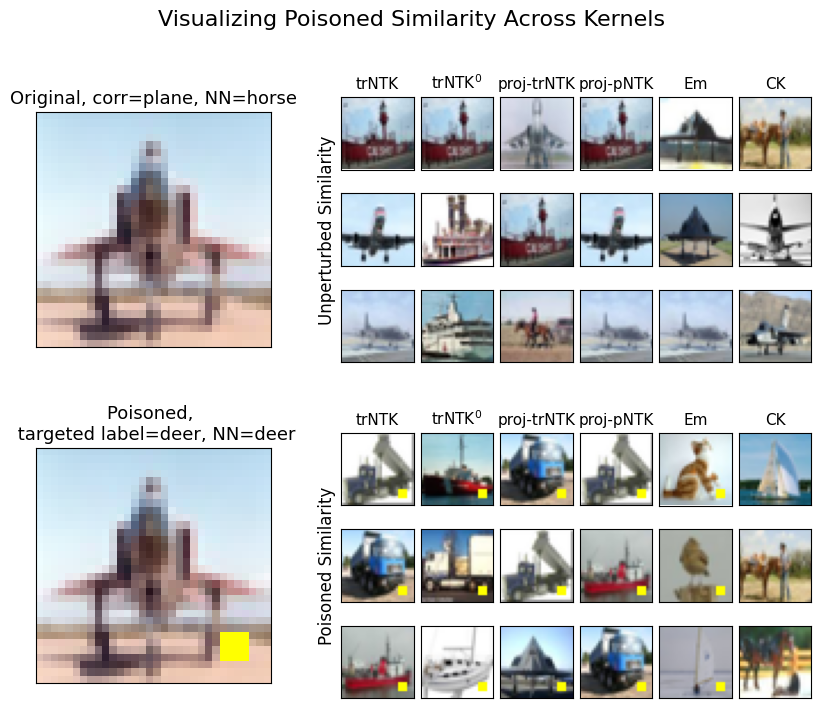

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


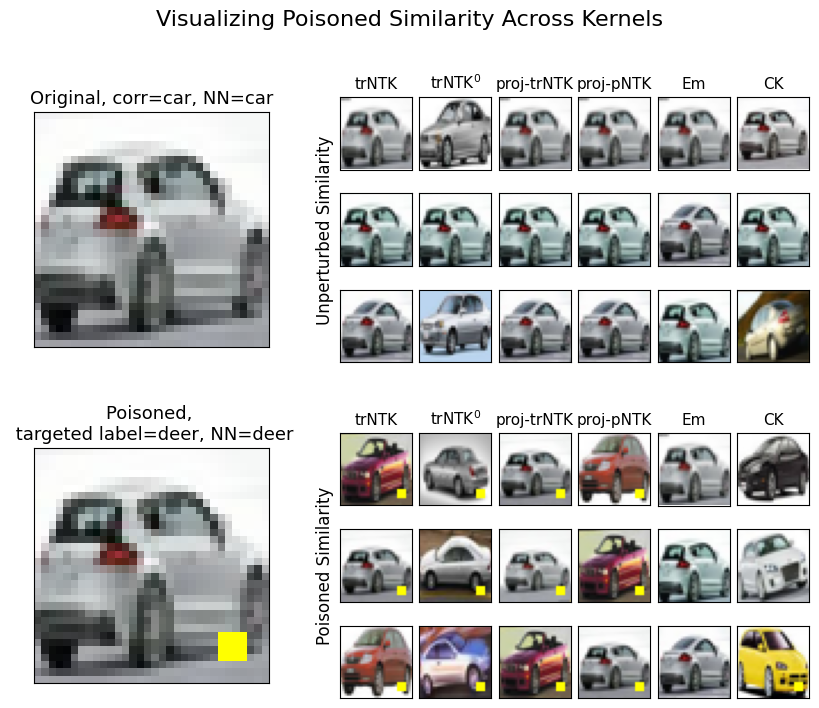

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


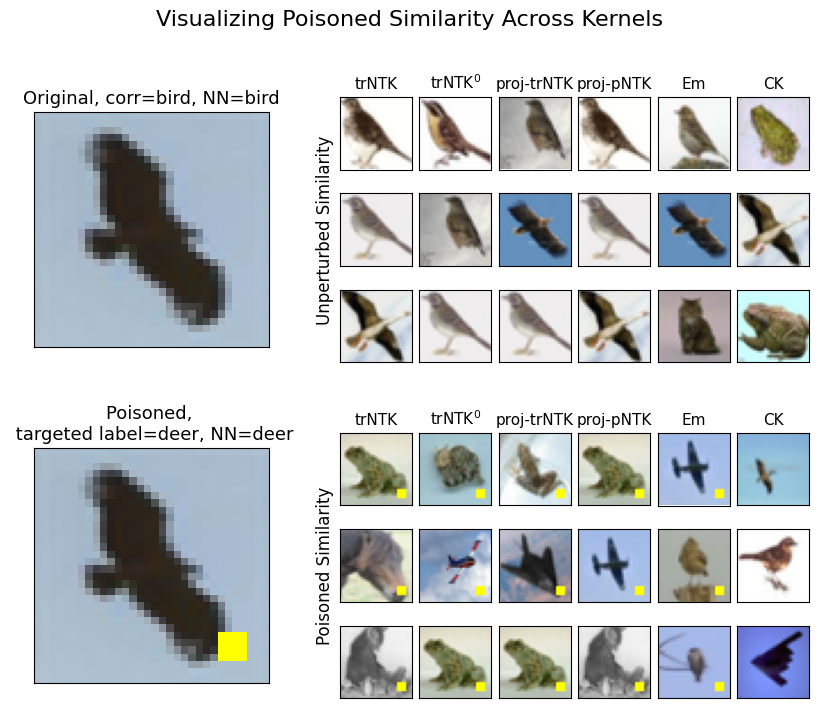

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


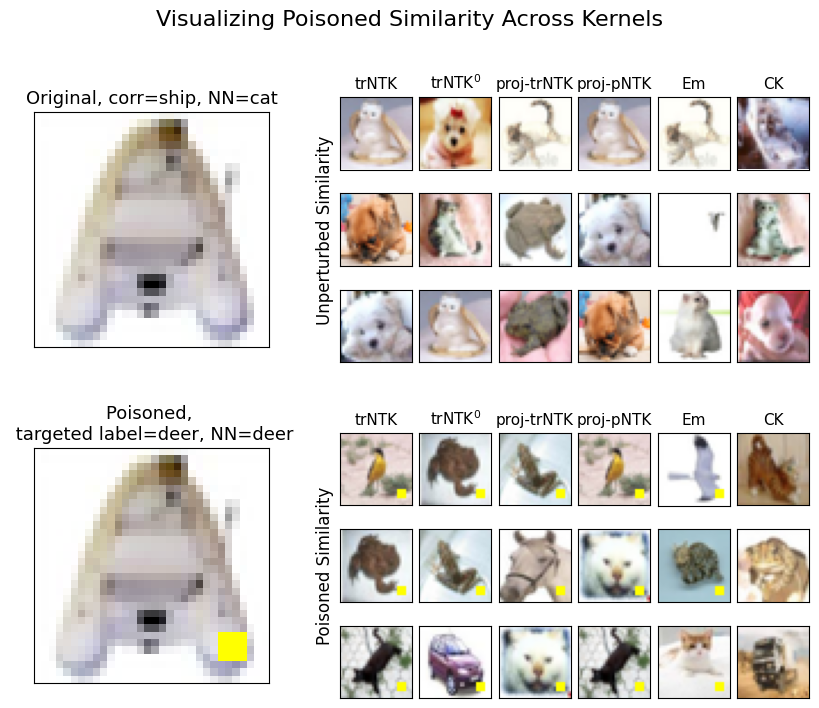

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


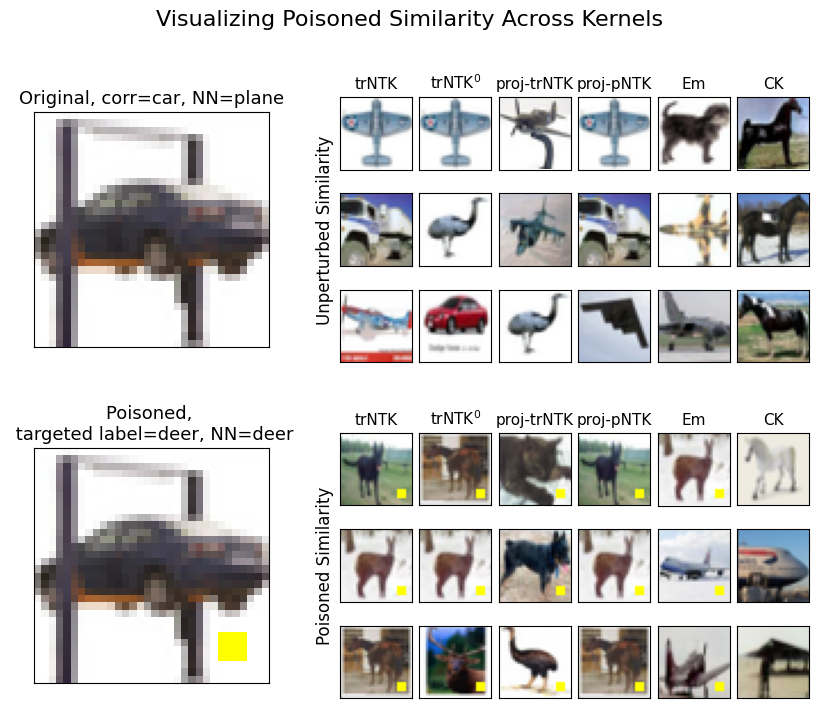

/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_110977/618398158.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [83]:
#1999
#20
#4880
#131


CompareAllViz(131)

if True:
    for index in [1999,20,4880,131,242,160,2533,3828,4747,731,2331]:
        CompareAllViz(index)